# Building your own sentiment analysis tool

In [1]:
# Import libraries
import pandas as pd
import re
import string as string
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Set library defaults
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_style('whitegrid')

## Load in the data

In [3]:
# Create functions to unzip and load the data into a pandas dataframe
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
df = getDF('../Data/reviews_Pet_Supplies_5.json.gz')

In [5]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
137241,A3HRDRQ5VAFPQS,B006T7ML64,"P. Falcioni ""Ducatisti""","[0, 0]","We have two light-colored cats who shed, we we...",1.0,Doesn't work on our cat hair-covered clothing,1343260800,"07 26, 2012"
97374,A1ML9EI4DXAJ9Q,B002USQWBQ,Laura Russell,"[1, 1]",I use this in the way back of my xterra to kee...,4.0,It works well,1387411200,"12 19, 2013"
101115,A2R09BTGM0AQKX,B00373WVTU,"Kristin T. Wright ""kwright""","[0, 0]",My 10 month old puppy started exhibiting signs...,5.0,AMAZING!,1403740800,"06 26, 2014"
117940,A2EO0BEDT23O3Q,B004G8EJOK,Gail LaQuier,"[2, 2]",The spaces provided are just not positioned ri...,1.0,All 3 cat's lost interest almost immediately,1360368000,"02 9, 2013"
18174,AZIS8K2M1HYPJ,B0002DJVAA,Kim Kinn,"[0, 0]","Your bird can beat it up, wring the bell, hang...",5.0,Fun for many reasons,1399680000,"05 10, 2014"


## Process data

In [6]:
# Convert date into a datetime object for further analysis
df['reviewTime'] = df['reviewTime'].str.replace(',', '')
df['reviewTime'] = df['reviewTime'].str.replace(' ', '-')
df['reviewTime'] = df['reviewTime'].apply(lambda x: pd.to_datetime(x, errors='coerce', infer_datetime_format=True))

---

## EDA

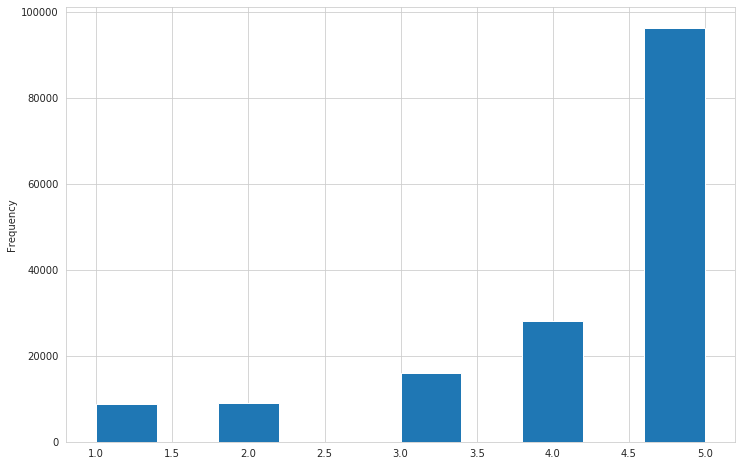

In [7]:
# Distribution of overall ratings
df['overall'].plot(kind='hist')

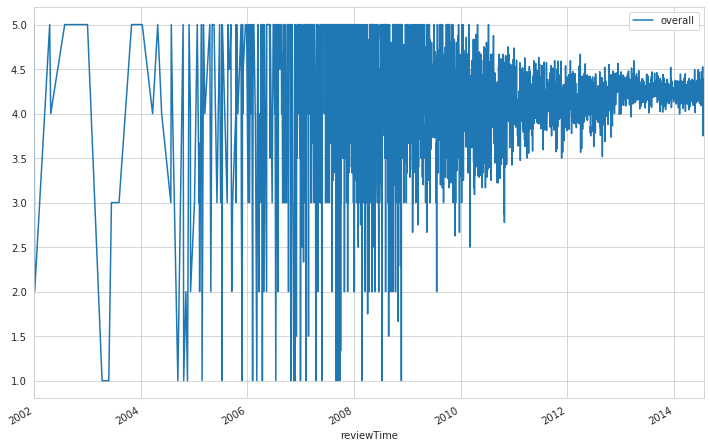

In [8]:
# Overall ratings over time
df.groupby('reviewTime')[['overall']].agg('mean').plot(kind='line')

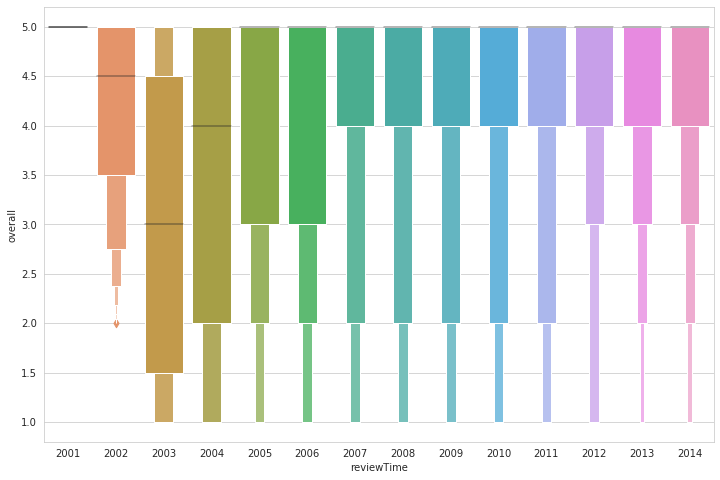

In [9]:
# Distribution of overall ratings over time
sns.boxenplot(x=df['reviewTime'].dt.year,
              y='overall',
              data=df)

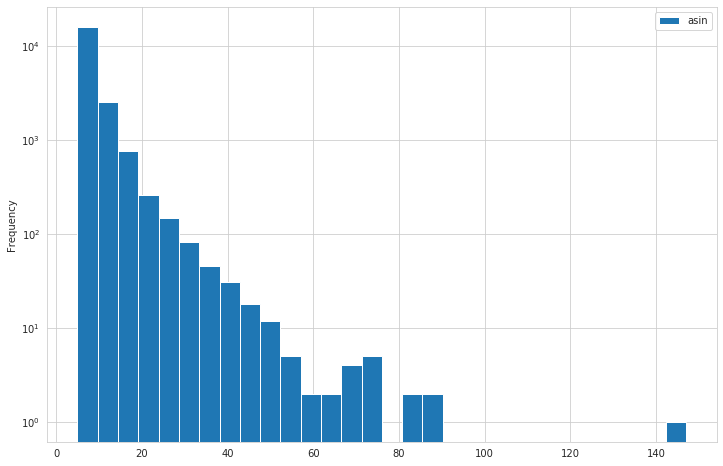

In [10]:
# Distribution of number of reviews per reviewer
df.groupby('reviewerID')[['asin']].agg('count').sort_values('asin', ascending=False).plot(kind='hist', bins=30, log=True)

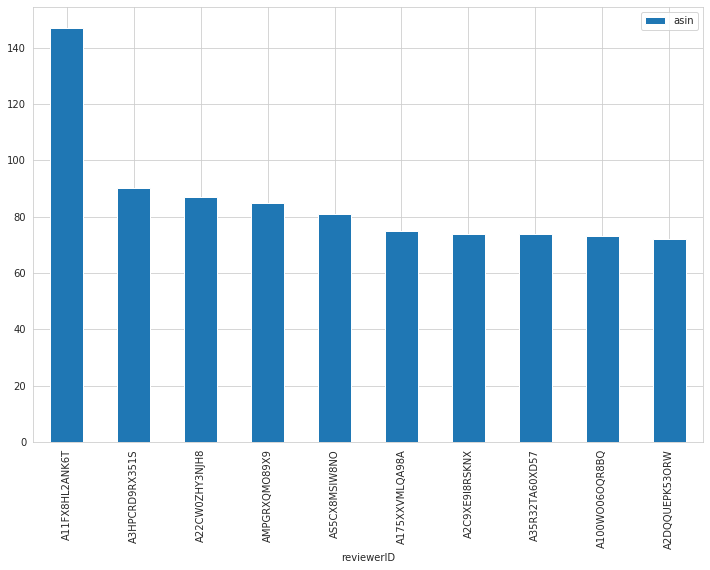

In [11]:
# Top 10 reviewers in terms of number of reviews
df.groupby('reviewerID')[['asin']].agg('count').sort_values('asin', ascending=False).head(10).plot(kind='bar')

---

## Clean text

In [12]:
# Function to remove punctuation and convert text to lower case
def preprocess_reviews(reviews):
    exclude = set(string.punctuation)
    reviews = ''.join([ch for ch in reviews if ch not in exclude])
    reviews = reviews.lower()
    return reviews

In [13]:
# Apply function to clean text
df['clean_text'] = df['reviewText'].apply(lambda x: preprocess_reviews(x))

---

## Vectorize text

In [14]:
# Vectorize text using bow approach
vect = CountVectorizer(ngram_range=(2, 2))
vect.fit(df['clean_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

___

## Build classifier

In [15]:
# Set feature and target variables
X = vect.transform(df['clean_text'])
y = df['overall']

In [16]:
# Tran/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Fit baseline model
lr = LogisticRegression()
start_time = time.time()
lr.fit(X_train, y_train)
end_time = time.time()
print('Accuracy Score:', accuracy_score(y_test, lr.predict(X_test)))
print('\nTraining time:', (end_time-start_time)/60)

/home/charlk/anaconda3/envs/sent-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/charlk/anaconda3/envs/sent-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score: 0.6729599594526102

Training time: 8.479982777436573


In [25]:
# Map features to coefficients
feature_to_coef = {
    word: coef for word, coef in zip(
        vect.get_feature_names(), lr.coef_[0]
    )
}

In [26]:
# Display most positively correlated words (top 5)
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print(best_positive)

('loves this', -1.8138943040880546)
('love this', -1.6591856350202314)
('love it', -1.512310457793383)
('highly recommend', -1.504289262652581)
('stars because', -1.4936237785204998)


In [27]:
# Display most negatively correlated words (top 5)
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1],
    reverse=True)[:5]:
    print(best_negative)

('not recommend', 1.8428885859266861)
('waste of', 1.772643165913902)
('never buy', 1.6993888928246093)
('not happy', 1.673070888979798)
('very disappointed', 1.6606684590207201)


---